In [2]:
import numpy as np
from PIL import Image
from scipy.sparse import coo_array, vstack, dia_array, linalg 
import matplotlib.pyplot as plt
import time
import random

In [3]:
#gaussian reg

#the reshaping is that in the substraction now we get every comination of input vector x and x_2 

def exp_kern(x,x_2,g,h,limit):
    x = x.T.reshape(2,1,-1)
    x_2 = x_2.T.reshape(2,-1,1)
    mixing_mat = np.exp(-np.sqrt(np.linalg.norm(x-x_2,ord = 2, axis = 0)/h**2)**g)
    return np.where(mixing_mat<limit,0,mixing_mat)





In [4]:
im = Image.open("cc_90.png")
pix_val = np.array(list(im.getdata()))
width, height = im.size
xx,yy = np.meshgrid(np.arange(im.size[0]),np.arange(im.size[1]))
xx = xx.flatten()
yy = yy.flatten()
coordinates = np.column_stack((xx,yy))
active_coordinates = coordinates[pix_val!=0]
pred_coordinates = coordinates[pix_val==0]


In [5]:


def calc_z(active_coordinates, pix_val,gamma,h,sigma, limit = 0.1):
    A = exp_kern(active_coordinates,active_coordinates,gamma,h,limit)
    sA = coo_array(A)

    diag = np.ones(A.shape[0])*sigma
    I = dia_array((diag,0),shape = (A.shape))
    z = linalg.spsolve(sA+I, pix_val[pix_val!=0])
    return z 


def calc_b(active_coordinates,pred_coordinates,gamma,h,limit = 0.1):
    b = exp_kern(active_coordinates,pred_coordinates[:25350],gamma,h,limit)
    sb=coo_array(b)
    b_2 = exp_kern(active_coordinates,pred_coordinates[25350:50700],gamma,h,limit)
    sb=vstack((sb,coo_array(b_2)))
    b_3 = exp_kern(active_coordinates,pred_coordinates[50700:76050],gamma,h,limit)
    sb=vstack((sb,coo_array(b_3)))

    return sb 

def predict_picture(z,sb,pix_val):
    y_pred = sb@z
    pix_val_pred = np.copy(pix_val)
    pix_val_pred = pix_val_pred.astype(float)

    pix_val_pred[np.where(pix_val_pred==0)[0]] = y_pred
    np.place(pix_val_pred,pix_val_pred == 0,y_pred)

    pred_im = np.reshape(pix_val_pred,(height,width))
    return Image.fromarray(pred_im)
 

    


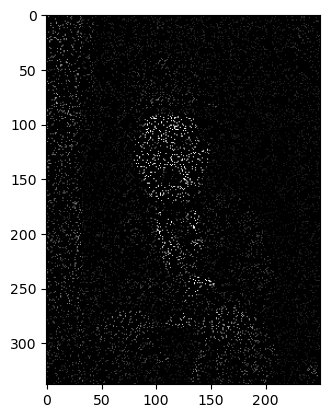

In [6]:
plt.imshow(im,cmap='gray')

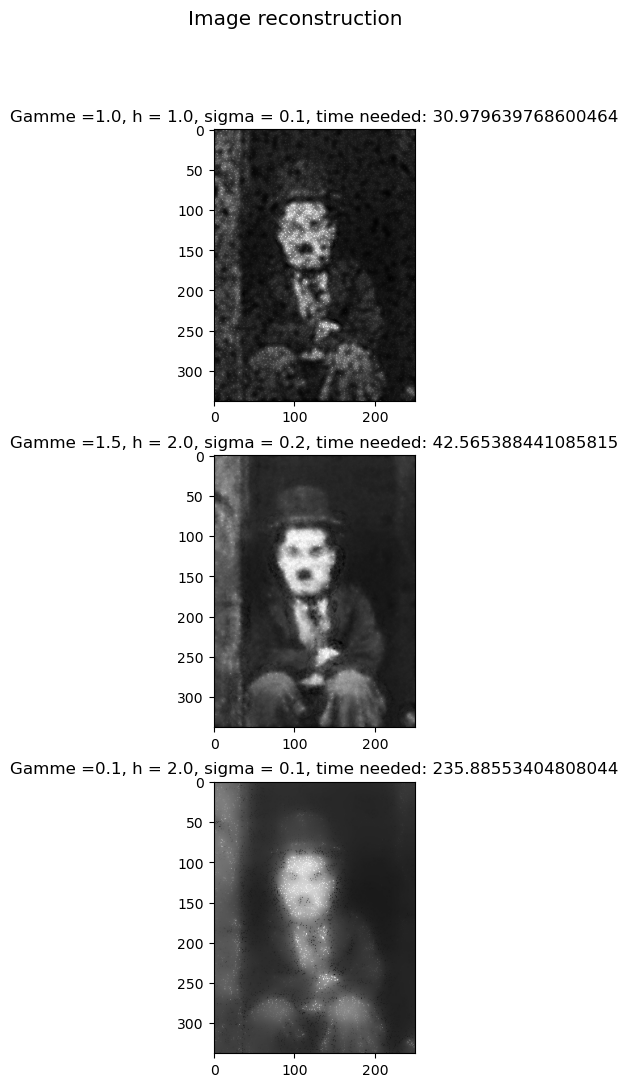

In [7]:

hyperparameter = np.array([[1,1,0.1],[1.5,2,0.2],[0.1,2,0.1]])# gamma,h,sigma

                           #[1.5,1,0.1],[1.5,1,1],[1.5,2,0.1],[1.5,2,1],[0.01,2,0.1]]) 

fig, ax = plt.subplots(3,1)
st = fig.suptitle("Image reconstruction", fontsize="x-large")
fig.set_figheight(12)
fig.set_figwidth(15)

for i,hyper in enumerate(hyperparameter):
    #plotting the different steps of pixel/feature selection
    gamma, h, sigma = hyper

    start = time.time()
    z = calc_z(active_coordinates, pix_val,gamma,h,sigma)
    b = calc_b(active_coordinates,pred_coordinates,gamma,h)
    pred_image =predict_picture(z,b,pix_val)
    end = time.time()
    ax.ravel()[i].imshow(pred_image,cmap='gray')
    ax.ravel()[i].set_title("Gamme =%s, h = %s, sigma = %s, time needed: %s" %(gamma, h, sigma, end-start))



We can see that a gamma of 1.5,h of 2 and sigma of 0.2 gives an okay result.
We can clearly see good charlie here.
If the h is to small the neigbouthood is to small, and therefore the picture becomes uneven.
If our Gamma is too small as in the last case, the neighbouthood exponential is decaying to slow and the picture becomes blurred. 

In [7]:
#nadaraya-watson method
def nad_wat(sb,pix_val):
    y_pred = sb@pix_val[pix_val!=0]
    y_pred = y_pred//linalg.norm(b,axis=1)
    pix_val_pred = np.copy(pix_val)
    pix_val_pred = pix_val_pred.astype(float)

    pix_val_pred[np.where(pix_val_pred==0)[0]] = y_pred
    np.place(pix_val_pred,pix_val_pred == 0,y_pred)

    pred_im = np.reshape(pix_val_pred,(height,width))
    return Image.fromarray(pred_im)




/tmp/ipykernel_14350/1192820414.py:4: RuntimeWarning: invalid value encountered in floor_divide
  y_pred = y_pred//linalg.norm(b,axis=1)


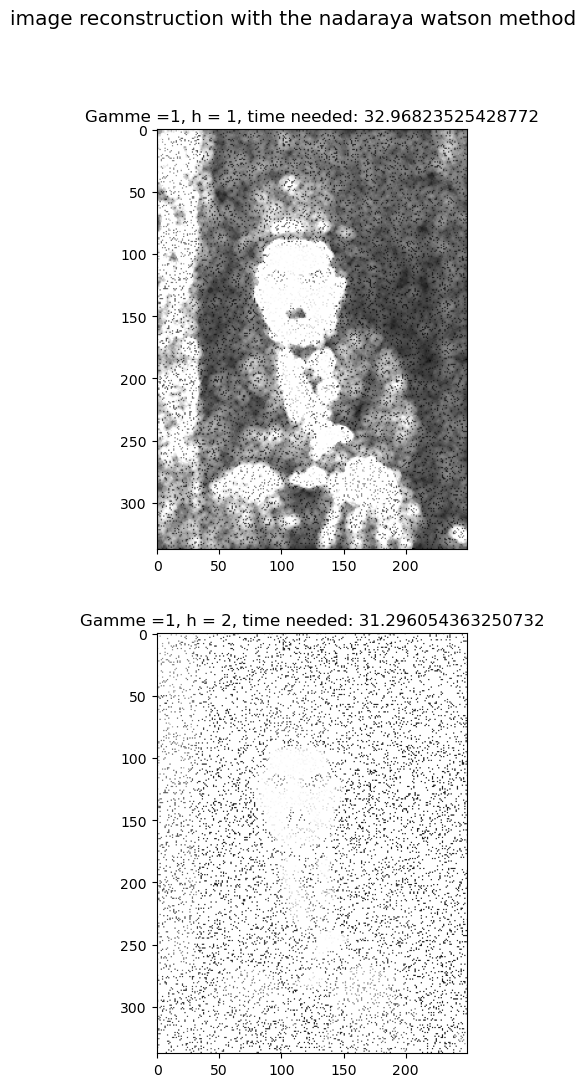

In [9]:
hyperparameter = np.array([[1,1],[1,2]])# gamma,h

fig, ax = plt.subplots(2,1)
st = fig.suptitle("image reconstruction with the nadaraya watson method", fontsize="x-large")
fig.set_figheight(12)
fig.set_figwidth(15)

for i,hyper in enumerate(hyperparameter):
    #plotting the different steps of pixel/feature selection
    gamma, h = hyper

    start = time.time()
    b = calc_b(active_coordinates,pred_coordinates,gamma,h)
    pred_image = nad_wat(b,pix_val)
    end = time.time()
    ax.ravel()[i].imshow(pred_image,cmap='gray')
    ax.ravel()[i].set_title("Gamme =%s, h = %s, time needed: %s" %(gamma, h, end-start))



The Image quality is much worse, also i tried different hyperparmeter but the kernel crashed.
Especially the calculation of b the way we did it is very intensive here and costs most of the time.
therefore there is not much of a gain in the calculation time using this method.
Calculating b in a more efficent way would be a primary goal here.


In [12]:
def circumcenter(A,B,C):
    B_s = B - A
    C_s = C - A
    D = 2*(B_s[0]*C_s[1]-B_s[1]*C_s[0])
    U_x = 1/D *(C_s[1]*(B_s[0]**2 + B_s[1]**2)- B_s[1]*(C_s[0]**2 + C_s[1]**2))
    U_y = 1/D *(-C_s[0]*(B_s[0]**2 + B_s[1]**2)+ B_s[0]*(C_s[0]**2 + C_s[1]**2))
    r = np.sqrt(U_x**2 + U_y**2)
    center = [U_x + A[0], U_y + A[1]]
    return r, center

In [13]:
data = np.load("circles.npy")

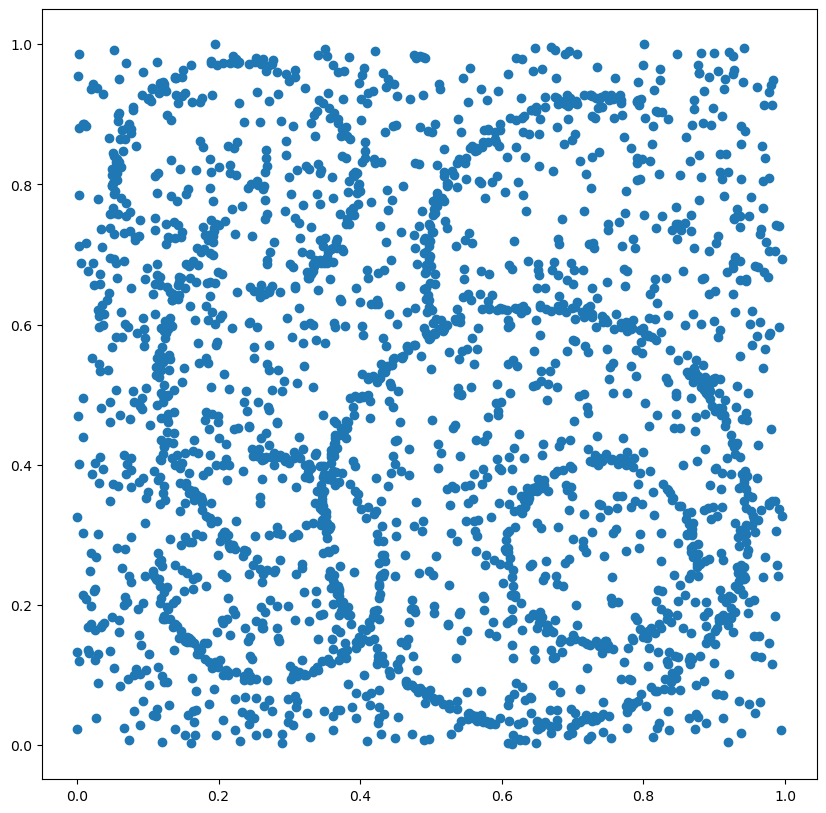

In [14]:
fig,ax = plt.subplots()

fig.set_figheight(10)
fig.set_figwidth(10)

ax.scatter(data[:,0],data[:,1])


Intuitivley I would read 6 circles out of it 

In [17]:




def circle_reg(eps,T,data):
    r_best,center_best = 0,[0,0]
    best_inliers=np.zeros(data.shape[0])

    for i in range(T):
        A,B,C = random.sample(list(data), 3)
        r, center = circumcenter(A,B,C)
        distances = np.linalg.norm(data - center, axis=1)
        inliers = np.where((distances < r+eps)  & (distances > r-eps),1,0)
        if ((np.sum(inliers)>np.sum(best_inliers)) & (r<1)):
            best_inliers = inliers
            r_best,center_best = r, center
    return r_best, center_best, best_inliers



N_circ = 10
eps = 0.01
T = 10000
data_used  = data
all_centers = []
all_r = [] 
for i in range(N_circ):
    r_best,center_best,best_inliers = circle_reg(eps,T,data_used)
    all_r.append(r_best)
    all_centers.append(center_best)
    data_used = data_used[best_inliers==0]

        

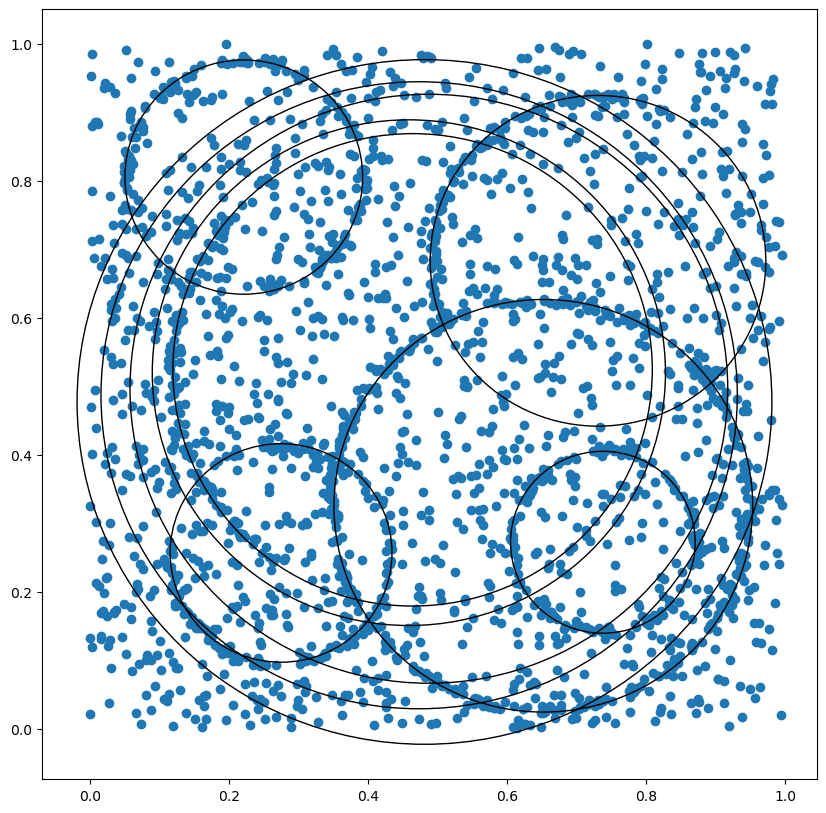

In [18]:

fig,ax = plt.subplots()

fig.set_figheight(10)
fig.set_figwidth(10)

ax.scatter(data[:,0],data[:,1])



for i in range(N_circ):
    circle = plt.Circle(( all_centers[i][0], all_centers[i][1] ) , radius =all_r[i] , fill = False ) # Create a circle
    plt.gca().add_patch( circle )

It achieved good results for a really small Epsilon, as otherwise the insencive is high to just make circles as big as possible as they would habe more inliners due to there size


For Exercise 2.2 and 2.3 we did not have enough time